In [1]:
from abc import *
import numpy as np
import matplotlib.pyplot as plt
from IPython.display import clear_output

import torch
import torch.nn as nn
import torch.optim as optim

In [2]:
device = torch.device("mps")

In [3]:
d = 20
T = 0.3

In [4]:
init_x = np.zeros((d))      # 20차원의 0벡터 ξ

In [5]:
def g(x):
    return 1.0 / (2.0 + 0.4 * torch.sum(x**2, dim=1, keepdim=True))     # numpy 보다 torch가 안전함

In [6]:
def derivative(y, t) : 
    return torch.autograd.grad(y, t, create_graph=True,\
                               grad_outputs=torch.ones(y.size()).to(device))[0]

## Neural network
with 5-layers and 256 neurons per hidden layer

In [7]:
class model(nn.Module) :
    def __init__(self, hidden_dims) :                    # Hidden_dims : [h1, h2, h3, ..., hn]
        super(model, self).__init__()
        
        self.layers = []
        for i in range(len(hidden_dims)-1) :
            self.layers.append(nn.Linear(hidden_dims[i], hidden_dims[i+1]))
        self.layers = nn.ModuleList(self.layers)
        
        for layer in self.layers :
            nn.init.xavier_uniform_(layer.weight)

        self.act = nn.Tanh()
        #self.act = nn.ReLU()
    
    def forward(self, x) :
        for layer in self.layers[:-1] :
            x = self.act(layer(x))
        x = self.layers[-1](x)
        return x

output => u(t,x), which is scalor

Thus, output layer should be 1 neuron.

and input dim be 21 <= t,x_init

In [8]:
network = model(hidden_dims=[21,256,256,256,256,256,1]).to(device)

## Loss Function

In [9]:
def compute_loss(network, t0, x0, dw, g_function,dt):
    x = x0
    t = t0
    input_tx = torch.cat([t, x], dim=1).requires_grad_()

    y = network(input_tx)
    
    loss = 0.0

    for n in range(15):
        grads = torch.autograd.grad(y, input_tx,
                                    grad_outputs=torch.ones_like(y),
                                    create_graph=True,
                                    retain_graph=True
                                    )[0]
        z = grads[:, 1:]
        dW = dw[:, n, :]

        y_pred_next = y + (-y + y**3) * dt + torch.sum(z * dW, dim=1, keepdim=True)     # φ = y + (-y + y**3) in allen cahn..

        # update x, t
        x = x + dW
        t = t + dt
        input_tx = torch.cat([t, x], dim=1).requires_grad_()
        y = network(input_tx)

        loss += torch.mean((y - y_pred_next) ** 2)

    g_target = g_function(x)
    terminal_loss = torch.mean((y - g_target) ** 2)

    return loss + terminal_loss


In [10]:
EPOCHS=10000

In [11]:
optimizer = optim.Adam(network.parameters(), lr=1e-4)
dt = T / 15

In [12]:
def sample_batch():
    x0 = torch.zeros(100, d).to(device)
    t0 = torch.zeros(100, 1).to(device)
    dw = torch.randn(100, 15, d).to(device) * (dt ** 0.5)
    return t0, x0, dw

In [13]:
loss_list = []
network.train()

for epoch in range(1, EPOCHS+1):
    optimizer.zero_grad()
    
    t_batch, x_batch, dw = sample_batch()
    
    loss = compute_loss(network, t_batch, x_batch, dw, g_function=g, dt=dt)

    loss.backward()
    optimizer.step()

    loss_list.append(loss.item())
    
    if epoch % 100 == 0:
        print(f"EPOCH : {epoch}/{EPOCHS} | Loss : {loss.item():.7f}")
        clear_output(wait=True)

print('Training Finished.')


Training Finished.


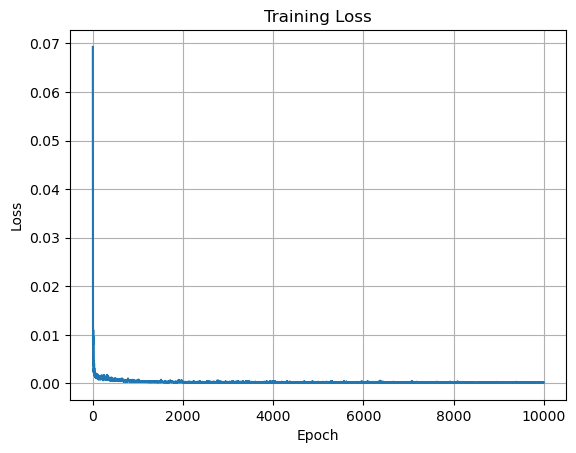

In [14]:
plt.plot(loss_list)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.grid(True)
plt.show()

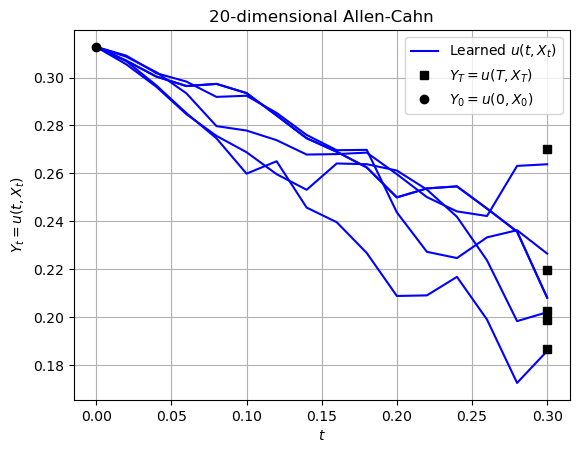

In [15]:
def simulate_trajectories(network, dt, N=15, samples=5):
    t_list = [torch.zeros(samples, 1).to(device)]
    x_list = [torch.zeros(samples, d).to(device)]
    y_list = []

    t = t_list[0]
    x = x_list[0]

    input_tx = torch.cat([t, x], dim=1)
    input_tx.requires_grad_()
    y = network(input_tx)
    y_list.append(y.detach().cpu().numpy())

    for n in range(N):
        dW = torch.randn(samples, d).to(device) * (dt ** 0.5)
        grads = torch.autograd.grad(y, input_tx, grad_outputs=torch.ones_like(y),
                                    create_graph=True, retain_graph=True)[0]
        z = grads[:, 1:]

        y = y + (-y + y**3) * dt + torch.sum(z * dW, dim=1, keepdim=True)

        x = x + dW
        t = t + dt

        t_list.append(t)
        x_list.append(x)

        input_tx = torch.cat([t, x], dim=1).requires_grad_()
        y = network(input_tx)
        y_list.append(y.detach().cpu().numpy())

    t_all = torch.cat(t_list, dim=1).cpu().numpy()[0]  # shape: (N+1,)
    y_all = np.stack(y_list, axis=1)  # shape: (samples, N+1, 1)

    x_final = x_list[-1]
    g_target = g(x_final).detach().cpu().numpy()  # shape: (samples, 1)
    y0_scalar = y_all[0, 0, 0]  # 첫 경로의 Y_0

    return t_all, y_all, g_target, y0_scalar

t_all, y_all, g_target, y0_scalar = simulate_trajectories(network, dt)

plt.figure()
for i in range(y_all.shape[0]):
    plt.plot(t_all, y_all[i,:,0], 'b')

plt.plot(t_all, y_all[0,:,0], 'b', label='Learned $u(t, X_t)$')
plt.plot([T]*y_all.shape[0], g_target, 'ks', label='$Y_T = u(T, X_T)$')
plt.plot([0], [y0_scalar], 'ko', label='$Y_0 = u(0, X_0)$')

plt.xlabel('$t$')
plt.ylabel('$Y_t = u(t, X_t)$')
plt.title('20-dimensional Allen-Cahn')
plt.legend()
plt.grid(True)
plt.show()


In [16]:
loss

tensor(0.0002, device='mps:0', grad_fn=<AddBackward0>)

In [17]:
with torch.no_grad():
    t0 = torch.zeros(1, 1).to(device)
    x0 = torch.zeros(1, d).to(device)
    input_tx = torch.cat([t0, x0], dim=1)

    u_00 = network(input_tx)
    print(f"u(0, X0) = {u_00.item():.5f}")


u(0, X0) = 0.31278
